# Introduction

QA plots for the TPC detector

In [1]:
# imports to write dynamic markdown contents
import os
from IPython.display import display, Markdown, Latex
from IPython.display import HTML

In [2]:
# turn off/on code for the result HTML page

display(Markdown('*For the result HTML page:* '))
    
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

*For the result HTML page:* 

## `pyROOT` env check

In [3]:
import ROOT

OFFLINE_MAIN = os.getenv("OFFLINE_MAIN")
if OFFLINE_MAIN is not None:
    display(Markdown(f"via sPHENIX software distribution at `{OFFLINE_MAIN}`"))

Welcome to JupyROOT 6.22/02


via sPHENIX software distribution at `/cvmfs/sphenix.sdcc.bnl.gov/gcc-8.3/release/release_new/new.2`


# Initialization

In [4]:
%%cpp -d


#include <sPhenixStyle.C>

#include <TFile.h>
#include <TLine.h>
#include <TString.h>
#include <TTree.h>
#include <cassert>
#include <cmath>

In [5]:
%%cpp

SetsPhenixStyle();
TVirtualFitter::SetDefaultFitter("Minuit2");


sPhenixStyle: Applying nominal settings.
sPhenixStyle: ROOT6 mode


## Inputs and file checks

In [6]:
%%cpp

TFile *qa_file_new = new TFile("singleElectron.lst_BECAL.2k.root");
// TFile *qa_file_new = new TFile("singlePion.lst_BECAL.2k.root");


    
if (qa_file_new == nullptr) 
{
    cout <<"Error, can not open QA root file"<<qa_file_name_new<<endl;
    exit(1);
}

TTree * T = nullptr; 

qa_file_new->GetObject("T", T);

    
if (T == nullptr) 
{
    cout <<"Error, can not open T Tree"<<endl;
    exit(1);
}

# What is in the TTree

Every entry is for one truth particle 

* `m_truth*`: is the MC truth information
  - `m_truthpid`: is the PID in PDG convension
* `m_tr*`: is the recontructed track information
* `BECAL_proj_*`: is the Kalman filter track projection to the reference radius of BECAL
* `Tower_E3x3...7x7`: is using the track projection as seed and build 3x3 to 7x7 tower energy sum 
* `centralTowerBinEta` and `centralTowerBinPhi`: are the tower at the track projection
* `Tower_*` is the 1D array for towers in a 7x7 patch next to the track projection. 
  - `dEta/phi` are tower to track distance in eta/phi scale. 
  - `iEta_patch/phi` are tower id in the patch relative to the central tower
  - `E` are energy of that tower
  

In [7]:
%%cpp
T->Show(0);

======> EVENT:0
 m_truthenergy   = 1.82491
 m_truthp        = 1.82491
 m_truthpx       = -1.047
 m_truthpy       = 1.4914
 m_truthpz       = -0.0992214
 m_truthpt       = 1.82221
 m_truthphi      = 2.18288
 m_trutheta      = -0.0544242
 m_truthpid      = 11
 m_tr_px         = -1.03569
 m_tr_py         = 1.47538
 m_tr_pz         = -0.0971303
 m_tr_p          = 1.80522
 m_tr_pt         = 1.80261
 m_tr_phi        = 2.18285
 m_tr_eta        = -0.0538571
 m_charge        = -1
 m_chisq         = 8.12215
 m_ndf           = 13
 m_dca           = 0.00205041
 m_tr_x          = 2.38555e-05
 m_tr_y          = 1.70036e-05
 m_tr_z          = 2.34268
 BECAL_proj_x    = -72.4713
 BECAL_proj_y    = 79.7369
 BECAL_proj_z    = -3.47849
 BECAL_proj_path_length = 108.192
 BECAL_proj_px   = -1.36203
 BECAL_proj_py   = 1.16405
 BECAL_proj_pz   = -0.0965261
 Tower_E3x3      = 1.235
 Tower_E5x5      = 1.5644
 Tower_E7x7      = 1.5976
 centralTowerBinEta = 30
 centralTowerBinPhi = 48
 nTowerInPatch   = 49
 Towe

# Suggestion

General event selection: 

`abs(m_tr_p/m_truthp)<5%`, i.e. the track that can be propery reconstructed and useful for analysis. This kick out the electron with hard bremsstrahlung, which is a quite different problem to deal with. We probably want to run the classification with each eta and momentum bin. The current sample is generated within |eta|<0.5, in which BCAL performance is similar. And the momentum cover from 0-20GeV, and we can probably focus on the 2-4 GeV region where physics impact is max.

Select the follow features in NN classifier input, which take into account of the azimuthal symmetry: 

* `m_tr_p`
* `m_tr_phi`
* `m_tr_eta`
* `Tower_dEta[49]`
* `Tower_dPhi[49]`
* `Tower_E[49]`

And then I would expect NN should learn about both e/p and shower shape from these variables 

Last to compare ROC curves with 

* `E5x5/m_tr_p` cut only
* cut on NN classification output

We should see a big improvement over all electron efficiency region.

# Check plot

## E/p

Check 7x7 tower sum next to track projection vs turth or reco momentum

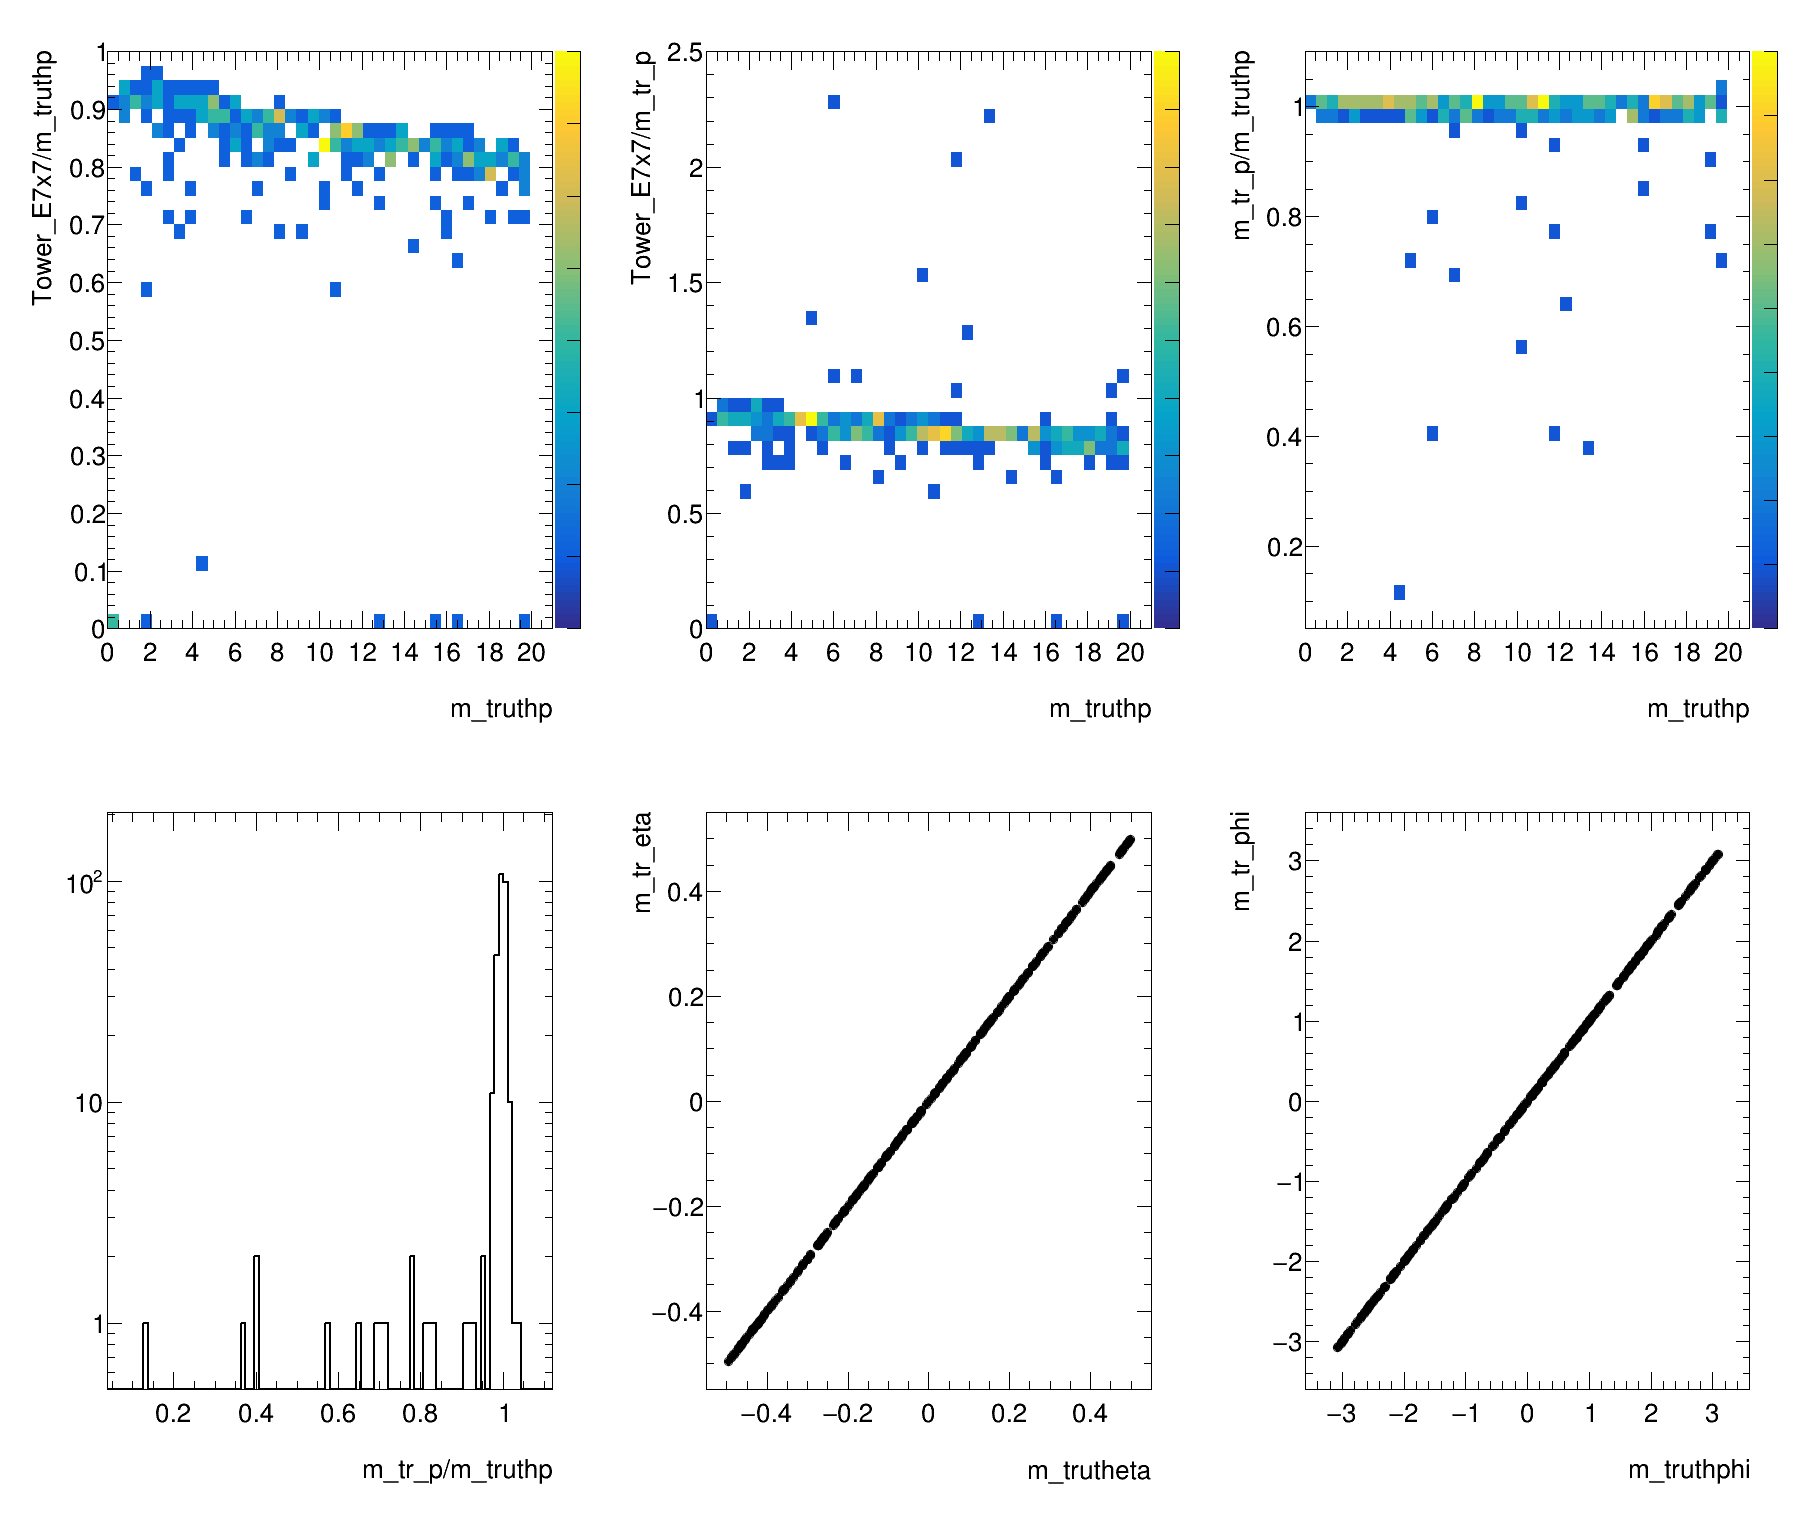

In [8]:
%%cpp

{

    
    const char *hist_name_prefix = "TowerScan";
    auto c1 = new TCanvas(TString("TowerScan") ,
                        TString("TowerScan"),
                        1800, 1550);

    c1->Divide(3, 2);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        // p->SetLogy();
        
        T->Draw("Tower_E7x7/m_truthp:m_truthp","","colz");
        
    }
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        // p->SetLogy();
        
        T->Draw("Tower_E7x7/m_tr_p:m_truthp","m_tr_p>0","colz");
    }
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        // p->SetLogy();
        
        T->Draw("m_tr_p/m_truthp:m_truthp","m_tr_p>0","colz");
    }
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
        T->Draw("m_tr_p/m_truthp","m_tr_p>0");
    }
    
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        //p->SetLogy();
        
        T->Draw("m_tr_eta:m_trutheta","m_tr_p>0");
    }
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        //p->SetLogy();
        
        T->Draw("m_tr_phi:m_truthphi","m_tr_p>0");
    }
    
    
    
    c1->Draw();
}

## Track based shower profile check

Check 7x7 tower patch next to the track projection with weight of the tower energy


Warning in <TCanvas::Constructor>: Deleting canvas with same name: TowerScan


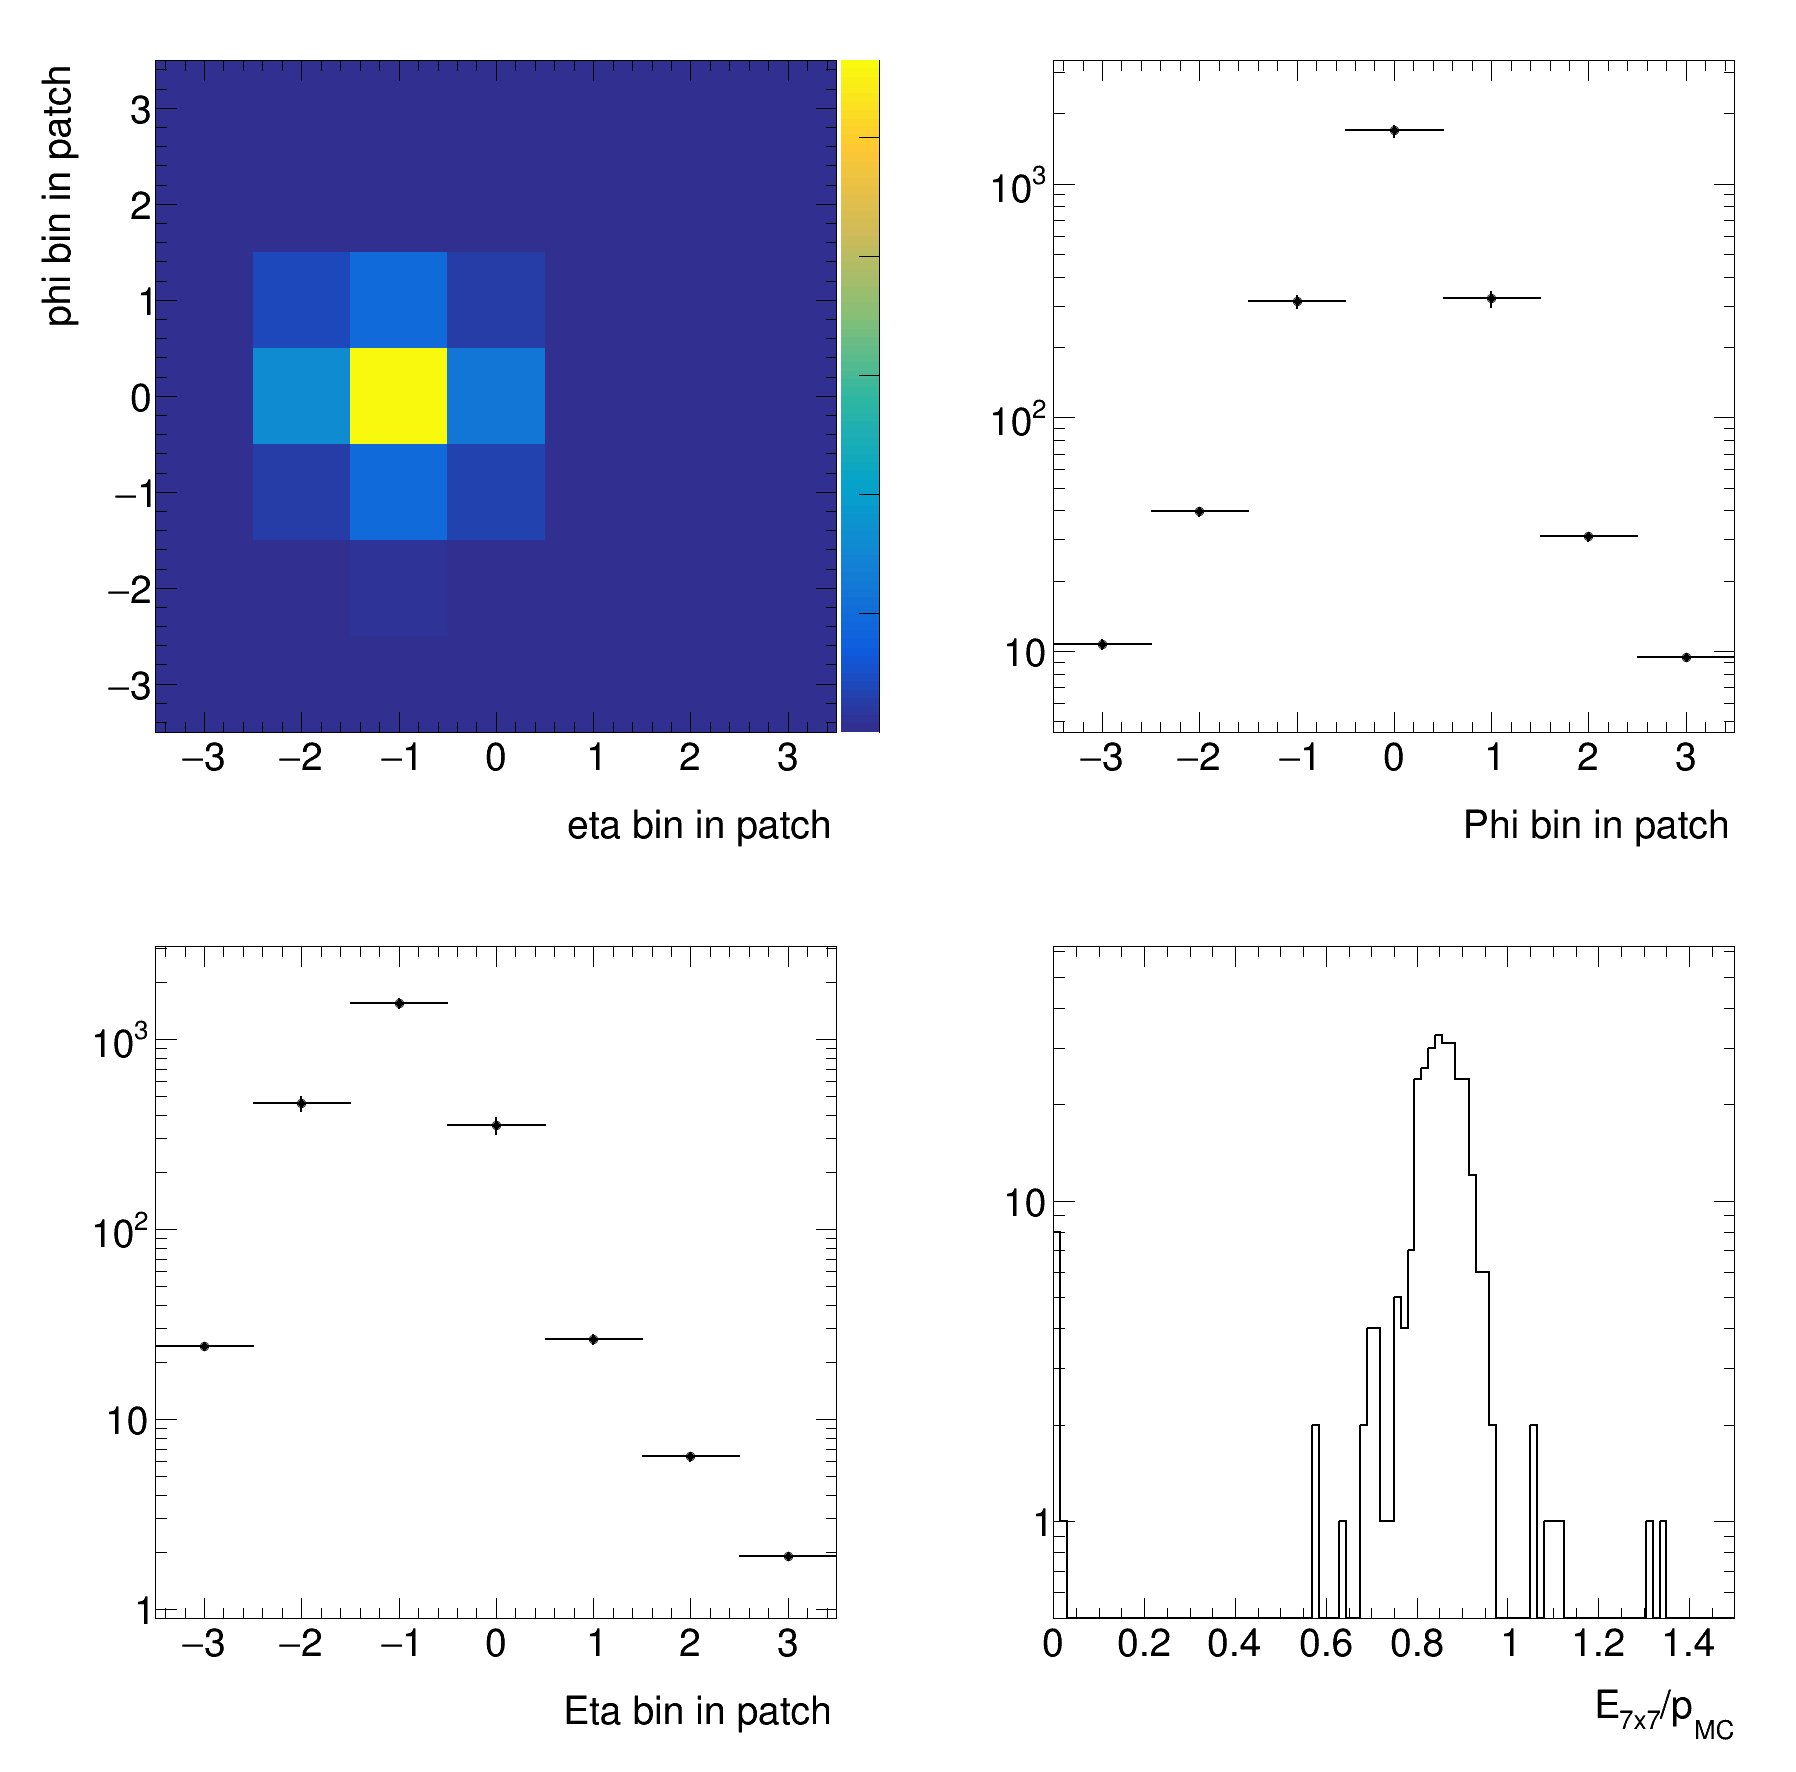

In [9]:
%%cpp

{

    
    const char *hist_name_prefix = "TowerScan";
    auto c1 = new TCanvas(TString("TowerScan") ,
                        TString("TowerScan"),
                        1800, 1800);

    c1->Divide(2, 2);
    int idx = 1;
    TPad *p;

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        // p->SetLogy();
        
        new TH2F("hpatch2D",";eta bin in patch;phi bin in patch",7,-3.5,3.5,7,-3.5,3.5);
        T->Draw("Tower_iPhi_patch:Tower_iEta_patch>>hpatch2D","Tower_E","colz");
        
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
        new TH1F("hpatchPhi",";Phi bin in patch",7,-3.5,3.5);
        T->Draw("Tower_iPhi_patch>>hpatchPhi","Tower_E","colz");
        
    }

    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
        p->SetLogy();
        
        new TH1F("hpatchEta",";Eta bin in patch",7,-3.5,3.5);
        T->Draw("Tower_iEta_patch>>hpatchEta","Tower_E","colz");
        
    }
    
    {
        p = (TPad *) c1->cd(idx++);
        c1->Update();
         p->SetLogy();
        
        new TH1F("hE7x7pTruth",";E_{7x7}/p_{MC}",100,0,1.5);
        T->Draw("Tower_E7x7/m_tr_p>>hE7x7pTruth");
    }
    
    
    
    c1->Draw();
}